In [1]:
import numpy as np
import os
import pickle

import gym
import matplotlib.pyplot as plt
#from scripts.buffer_utils import LoadSequenceDataset
%matplotlib inline

In [2]:
import h5py

In [3]:
import collections

In [4]:
import d4rl

No module named 'flow'
/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Nov 28 2023 23:51:11


In [5]:
import pdb

In [6]:
def get_keys(h5file):
    keys = []

    def visitor(name, item):
        if isinstance(item, h5py.Dataset):
            keys.append(name)

    h5file.visititems(visitor)
    return keys

In [7]:

def load_data(data_path):
    data_dict = {}
    with h5py.File(data_path, "r", libver="latest", swmr=True) as dataset_file:
        for k in get_keys(dataset_file):
            try:  # first try loading as an array
                data_dict[k] = dataset_file[k][:]
            except ValueError as e:  # try loading as a scalar
                data_dict[k] = dataset_file[k][()]

    return data_dict

In [11]:
mix_kitchen_env = gym.make('kitchen-mixed-v0')
mixed_data = mix_kitchen_env.get_dataset()

Reading configurations for Franka
Initializing Franka sim


/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 28.03it/s]


In [12]:
obs = mix_kitchen_env.reset()

In [13]:
partial_kitchen_env = gym.make('kitchen-partial-v0')
partial_data = partial_kitchen_env.get_dataset()

Reading configurations for Franka
Initializing Franka sim


load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.74it/s]


In [8]:
def sequence_dataset(dataset, kitchen=True):
    sequences = []

    N = dataset["rewards"].shape[0]
    data_ = collections.defaultdict(list)
    use_timeouts = "timeouts" in dataset

    episode_step = 0
    for i in range(N):
        done_bool = bool(dataset["terminals"][i])
        if use_timeouts:
            final_timestep = dataset["timeouts"][i]
        else:
            final_timestep = episode_step == env.max_episode_steps - 1

        for k in ["observations", "rewards", "actions", "terminals"]:
            if "metadata" in k:
                continue
            data_[k].append(dataset[k][i])

        if done_bool or final_timestep:
            episode_step = 0
            episode_data = {}
            for k in data_:
                episode_data[k] = np.array(data_[k])
            # sim_states = get_sim_states(env, episode_data["observations"])
            # episode_data["sim_states"] = sim_states

            if kitchen:
                episode_data = process_kitchen_episode(episode_data)
            # if dataset["terminals"][i]:
            #     episode_data['rewards'][-1] = -1.
            sequences.append(episode_data)
            data_ = collections.defaultdict(list)
            
        episode_step += 1
    return sequences

def process_kitchen_episode(episode):
    rewards_ = episode["rewards"][1:] - episode["rewards"][:-1]
    rewards = np.concatenate([episode["rewards"][:1], rewards_], axis=0)
    episode["rewards"] = rewards

    obs = episode["observations"]
    episode["observations"] = obs[:, :30]  # remove the goal
    return episode

In [107]:
mixed_sequences = sequence_dataset(mixed_data)
print(f'#. of trajectories in mixed dataset: {len(mixed_sequences)}')

partial_sequences = sequence_dataset(partial_data)
print(f'#. of trajectories in partial dataset: {len(partial_sequences)}')

#. of trajectories in mixed dataset: 613
#. of trajectories in partial dataset: 613


(array([  2.,   2.,   0.,   3.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.,  13.,  65.,  97., 131., 115.,  97.,  65.,  19.]),
 array([  8. ,  21.6,  35.2,  48.8,  62.4,  76. ,  89.6, 103.2, 116.8,
        130.4, 144. , 157.6, 171.2, 184.8, 198.4, 212. , 225.6, 239.2,
        252.8, 266.4, 280. ]),
 <BarContainer object of 20 artists>)

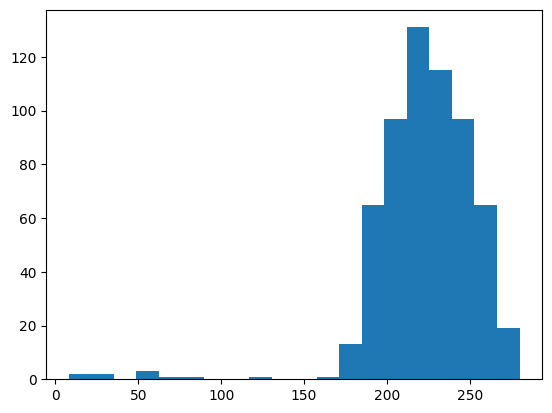

In [16]:
mixed_len = np.array([seq['observations'].shape[0] for seq in partial_sequences])
plt.hist(mixed_len, bins=20)

In [105]:
sum(mixed_len)

136950

(array([  2.,   2.,   0.,   3.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.,  13.,  65.,  97., 131., 115.,  97.,  65.,  19.]),
 array([  8. ,  21.6,  35.2,  48.8,  62.4,  76. ,  89.6, 103.2, 116.8,
        130.4, 144. , 157.6, 171.2, 184.8, 198.4, 212. , 225.6, 239.2,
        252.8, 266.4, 280. ]),
 <BarContainer object of 20 artists>)

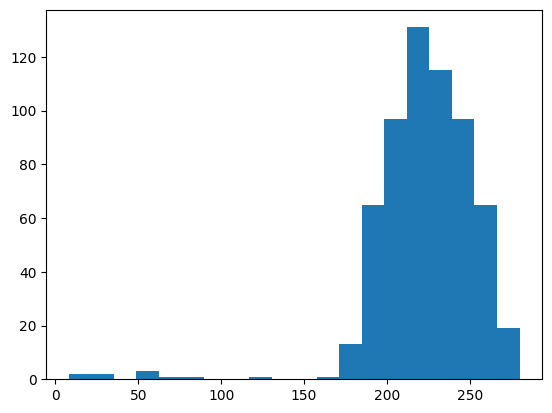

In [22]:
partial_len = np.array([seq['observations'].shape[0] for seq in partial_sequences])
plt.hist(partial_len, bins=20)

In [23]:
partial_sequences[0]['observations'].shape

(255, 30)

In [9]:
def comp_epi_return(dataset, discount=0.99):
    discounts = discount ** np.arange(1000)
    r = []
    for seq in dataset:
        rewards = seq['rewards']
        
        r_ = 0
        l = len(rewards)
        
        for i in range(l):
            r_ = (discounts[:l-i] * rewards[i:]).sum()
            r.append(r_)
        
    return r

In [18]:
mix_return = comp_epi_return(mixed_sequences)
partial_return = comp_epi_return(partial_sequences)

(array([3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.409e+03, 3.008e+03, 2.307e+03, 2.184e+03, 1.709e+03, 1.548e+03,
        1.814e+03, 1.809e+03, 1.810e+03, 2.105e+03, 2.092e+03, 2.045e+03,
        2.258e+03, 1.946e+03, 1.639e+03, 1.197e+03, 1.212e+03, 1.115e+03,
        9.640e+02, 9.980e+02, 7.230e+02, 4.100e+01, 2.000e+01, 1.300e+02,
        9.980e+02, 8.781e+03, 8.858e+03, 6.302e+03, 3.425e+03, 2.511e+03,
        2.555e+03, 2.585e+03, 2.579e+03, 2.757e+03, 3.296e+03, 3.206e+03,
        3.010e+03, 2.758e+03, 2.468e+03, 2.212e+03, 2.089e+03, 2.295e+03,
        2.494e+03, 2.650e+03, 2.721e+03, 2.676e+03, 2.625e+03, 2.630e+03,
        2.705e+03, 2.498e+03, 2.173e+03, 1.851e+03, 1.596e+03, 1.404e+03,
        1.257e+03, 1.189e+03, 1.094e+0

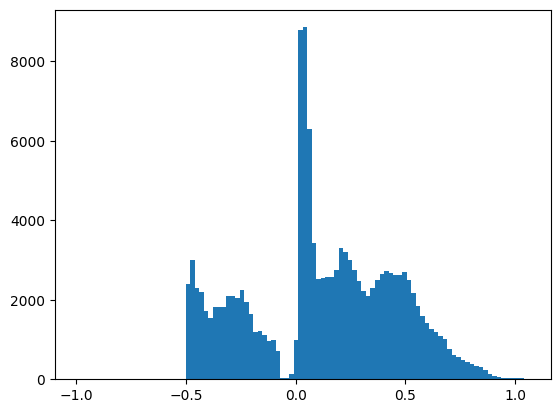

In [19]:
plt.hist(np.array(partial_return)/2, bins=100)

In [10]:
def comp_epi_return_v2(dataset, discount=0.99):
    discounts = discount ** np.arange(1000)
    r = []
    for seq in dataset:
        rewards = seq['rewards']
        
        r_ = 0
        l = len(rewards)
        r.append((discounts[:l] * rewards).sum())
        
        
    return r

In [21]:
partial_return = comp_epi_return_v2(partial_sequences)

(array([ 3., 19.,  7.,  3.,  1.,  0.,  1.,  7.,  9.,  6.,  3.,  0.,  1.,
         0.,  0.,  1.,  0.,  1.,  3.,  9., 15.,  6.,  5.,  5., 10.,  7.,
        15., 14., 16., 12., 28., 28., 24., 23., 13., 10., 18., 24., 28.,
        11.,  6.,  7., 10., 16., 31., 19.,  7., 11., 18., 26.,  9.,  7.,
         3.,  8.,  4.,  4.,  5.,  8.,  4.,  3.,  3.,  1.,  1.,  2.,  7.,
         4.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.04572422, 0.05560665, 0.06548908, 0.07537151, 0.08525395,
        0.09513638, 0.10501881, 0.11490124, 0.12478367, 0.1346661 ,
        0.14454853, 0.15443096, 0.16431339, 0.17419582, 0.18407826,
        0.19396069, 0.20384312, 0.21372555, 0.22360798, 0.23349041,
        0.24337284, 0.25325527, 0.2631377 , 0.27302014, 0.28290257,
        0.292785  , 0.30266743, 0.31254986, 0.32243229, 0.33231472,
        0.34219715, 0.3520

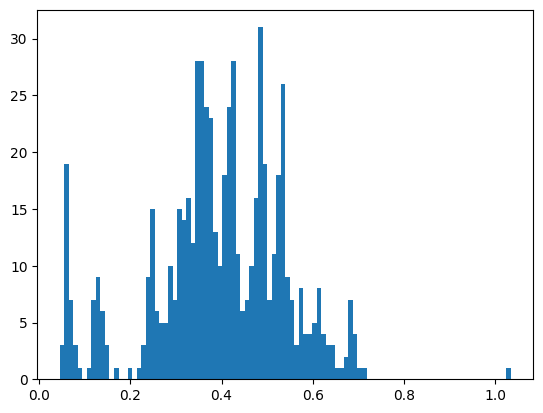

In [22]:
plt.hist(np.array(partial_return)/2, bins=100)

In [25]:
np.array(partial_return).argmax()

381

In [17]:
partial_reward = np.array([sum(seq['rewards']) for seq in partial_sequences])

(array([ 82.,   0.,   0., 261.,   0.,   0., 250.,   0.,   0.,  20.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

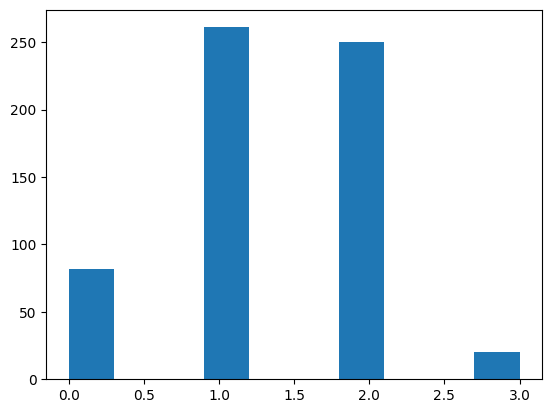

In [18]:
plt.hist(partial_reward)

In [156]:
max(np.array(partial_return)/2)

1.0605048115608924

In [95]:
hopper_medium = gym.make('hopper-medium-v2')
hopper_medium_data = hopper_medium.get_dataset()
hopper_medium_seq = sequence_dataset(hopper_medium_data, kitchen=False)
hopper_medium_return = comp_epi_return(hopper_medium_seq, discount=0.99)

load datafile: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 16.42it/s]


(array([ 19437.,  20015.,  23497.,  26466.,  32394.,  43833., 122493.,
        231423., 348720., 131628.]),
 array([  2.70320153,  38.19434047,  73.68547942, 109.17661836,
        144.6677573 , 180.15889624, 215.65003519, 251.14117413,
        286.63231307, 322.12345201, 357.61459095]),
 <BarContainer object of 10 artists>)

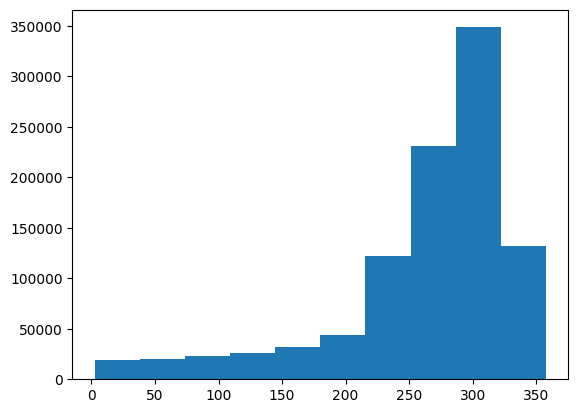

In [96]:
plt.hist(hopper_medium_return)

load datafile: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 15.51it/s]


(array([ 12152.,  13427.,  14487.,  17521.,  20330.,  27987.,  36258.,
         91037., 318981., 447314.]),
 array([-100.        ,  -48.33958092,    3.32083816,   54.98125724,
         106.64167632,  158.3020954 ,  209.96251448,  261.62293356,
         313.28335264,  364.94377172,  416.6041908 ]),
 <BarContainer object of 10 artists>)

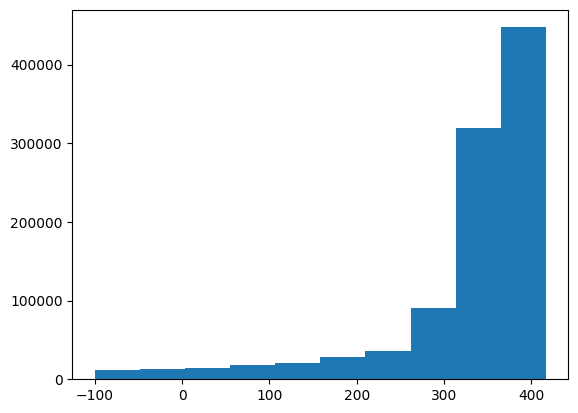

In [36]:
hopper_expert = gym.make('hopper-expert-v2')
hopper_expert_data = hopper_expert.get_dataset()
hopper_expert_seq = sequence_dataset(hopper_expert_data, kitchen=False)
hopper_expert_return = comp_epi_return(hopper_expert_seq, discount=0.99)
plt.hist(hopper_expert_return)

In [46]:
l = np.array([s['rewards'].shape[0] for s in hopper_expert_seq])

In [47]:
np.where(l < 1000)

(array([  15,   24,   35,   39,   42,   57,   64,   67,   87,  119,  122,
         125,  150,  154,  159,  161,  165,  183,  191,  192,  199,  203,
         211,  234,  245,  261,  274,  277,  291,  293,  309,  310,  335,
         338,  342,  348,  360,  363,  375,  386,  390,  394,  398,  403,
         404,  405,  408,  451,  464,  490,  497,  504,  537,  539,  541,
         548,  571,  577,  590,  600,  615,  627,  631,  654,  678,  690,
         694,  705,  724,  731,  763,  771,  775,  788,  794,  810,  818,
         842,  848,  864,  869,  905,  921,  929,  965,  969,  994, 1005,
        1025]),)

In [51]:
hopper_expert_seq[15]['rewards'][-1]

-100.0

load datafile: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 10.81it/s]


(array([1.71700e+03, 1.04000e+02, 1.01000e+02, 8.07000e+02, 1.29210e+04,
        2.00730e+04, 3.11210e+04, 5.49620e+04, 2.98329e+05, 4.79865e+05]),
 array([-41.14110225,  43.15976324, 127.46062874, 211.76149423,
        296.06235973, 380.36322522, 464.66409072, 548.96495621,
        633.26582171, 717.5666872 , 801.8675527 ]),
 <BarContainer object of 10 artists>)

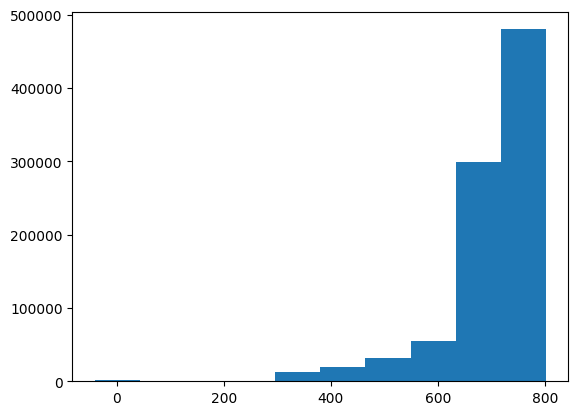

In [87]:
halfcheetah_expert = gym.make('halfcheetah-expert-v2')
halfcheetah_expert_data = halfcheetah_expert.get_dataset()
halfcheetah_expert_seq = sequence_dataset(halfcheetah_expert_data, kitchen=False)
halfcheetah_expert_return = comp_epi_return(halfcheetah_expert_seq)
plt.hist(halfcheetah_expert_return)

In [41]:
max(halfcheetah_expert_return)

760.4641136148024

In [22]:
full_trj[1]['observations'][-1,:30]

array([-2.4631360e+00, -1.2575334e+00,  1.1189899e+00, -1.7089678e+00,
        2.1164668e-01,  1.7132651e+00,  1.2239170e+00,  3.1033641e-02,
        2.4465717e-02, -3.5330103e-04, -4.5584628e-04,  4.4878609e-05,
        1.9409397e-05,  7.2409814e-05, -4.3590258e-06,  1.3306278e-06,
        8.1562457e-06, -6.9848257e-01, -4.9754199e-02,  3.9327744e-01,
        9.7954869e-03,  6.8391766e-03, -8.4681886e-01, -2.2606176e-01,
        7.7525604e-01,  1.6198332e+00,  9.9669641e-01, -9.0558939e-03,
        5.5062152e-03,  3.6503892e-02], dtype=float32)

In [26]:
np.unique(full_trj[0]['observations'][:,30:], axis=0)

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.69,
        -0.05,  0.37,  0.  ,  0.  , -0.75, -0.23,  0.75,  1.62,  0.99,
         0.  ,  0.  , -0.06]], dtype=float32)

 ===========   plot for the 0-th observation dim   =========== 


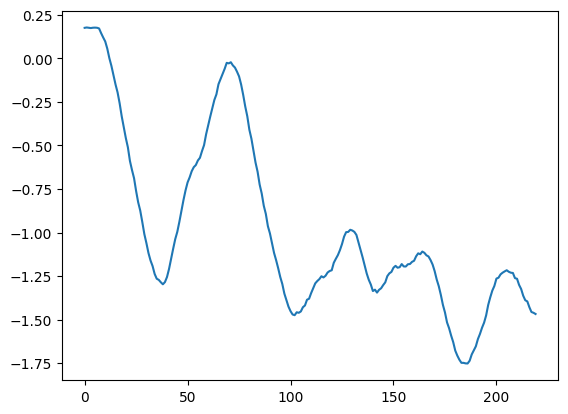

 ===========   plot for the 1-th observation dim   =========== 


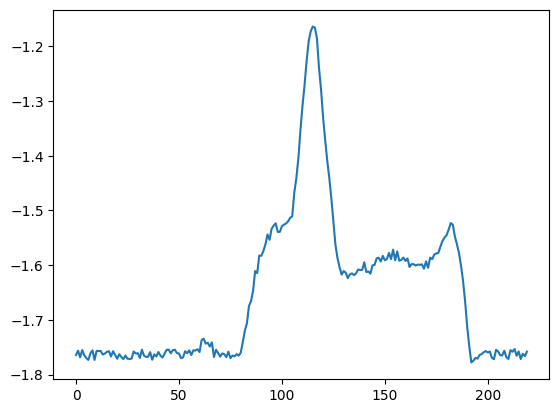

 ===========   plot for the 2-th observation dim   =========== 


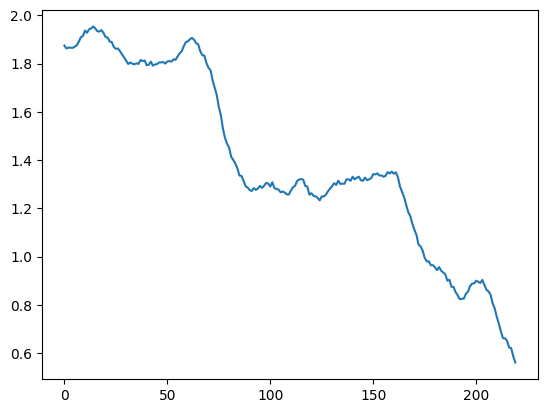

 ===========   plot for the 3-th observation dim   =========== 


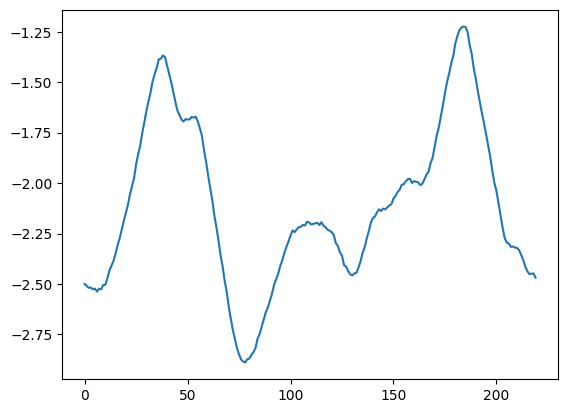

 ===========   plot for the 4-th observation dim   =========== 


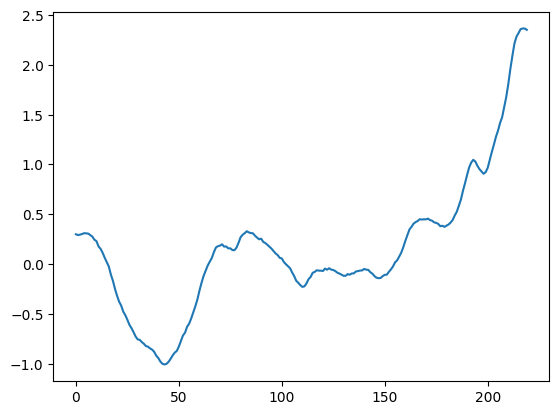

 ===========   plot for the 5-th observation dim   =========== 


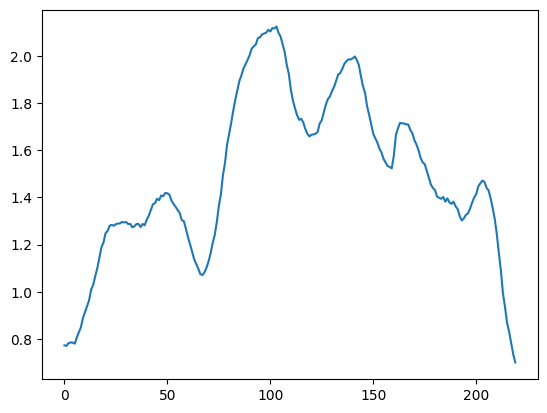

 ===========   plot for the 6-th observation dim   =========== 


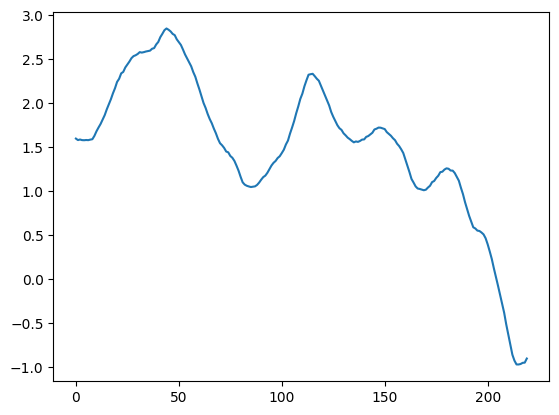

 ===========   plot for the 7-th observation dim   =========== 


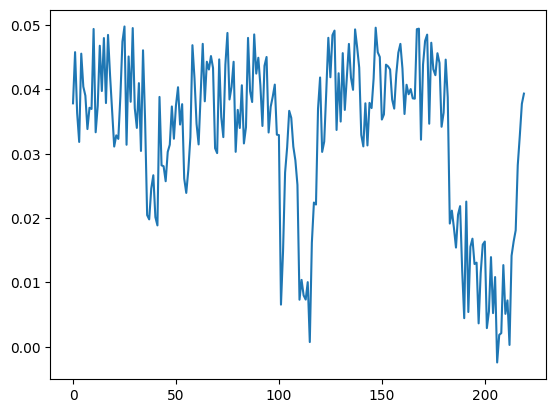

 ===========   plot for the 8-th observation dim   =========== 


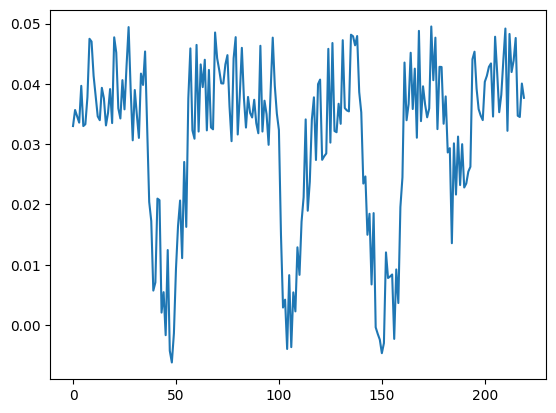

 ===========   plot for the 9-th observation dim   =========== 


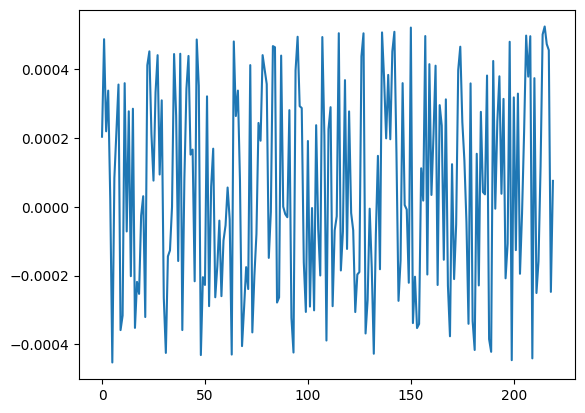

 ===========   plot for the 10-th observation dim   =========== 


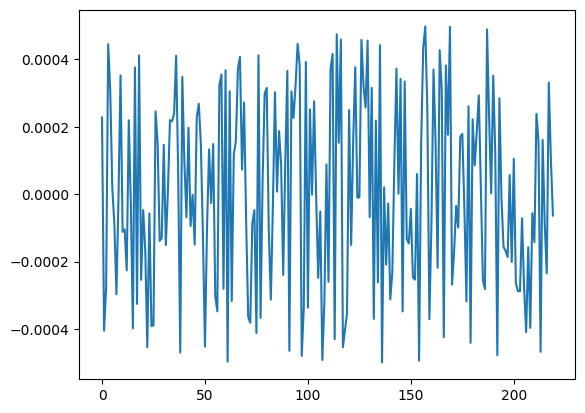

 ===========   plot for the 11-th observation dim   =========== 


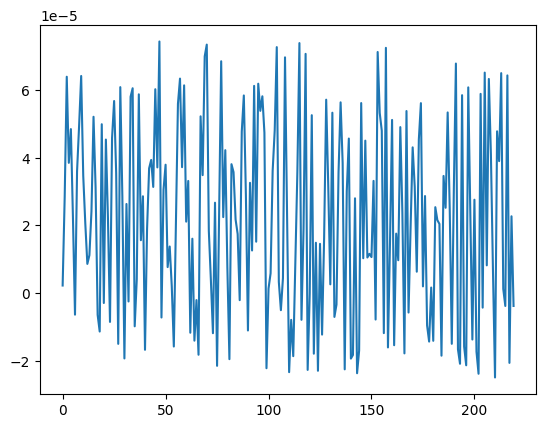

 ===========   plot for the 12-th observation dim   =========== 


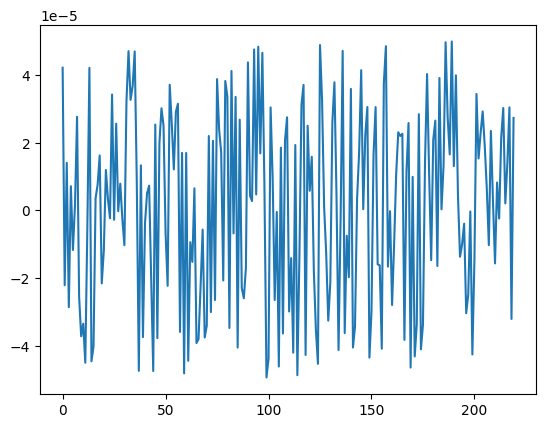

 ===========   plot for the 13-th observation dim   =========== 


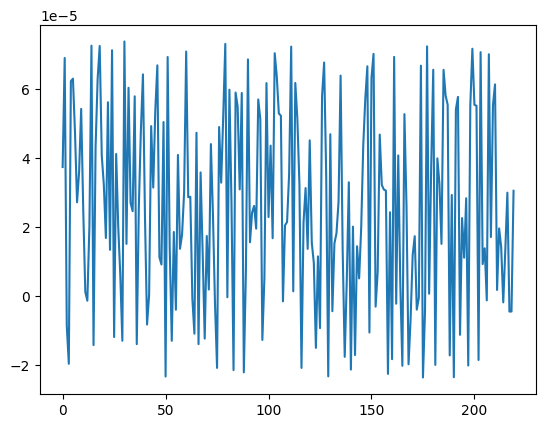

 ===========   plot for the 14-th observation dim   =========== 


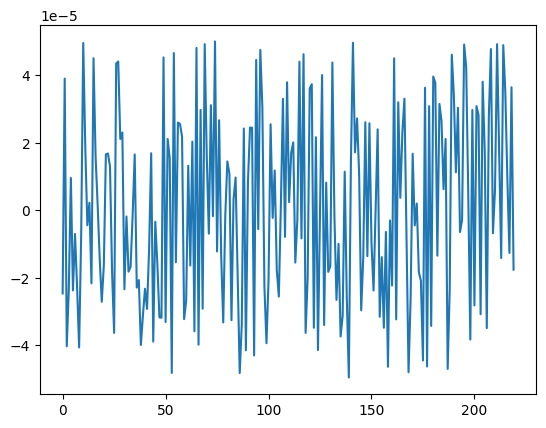

 ===========   plot for the 15-th observation dim   =========== 


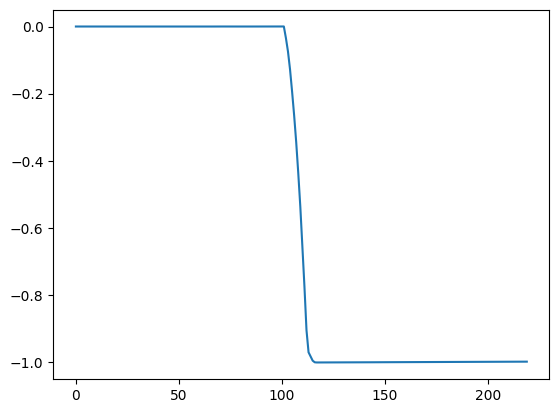

 ===========   plot for the 16-th observation dim   =========== 


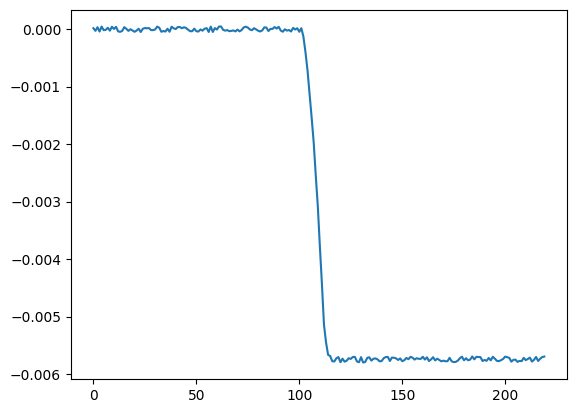

 ===========   plot for the 17-th observation dim   =========== 


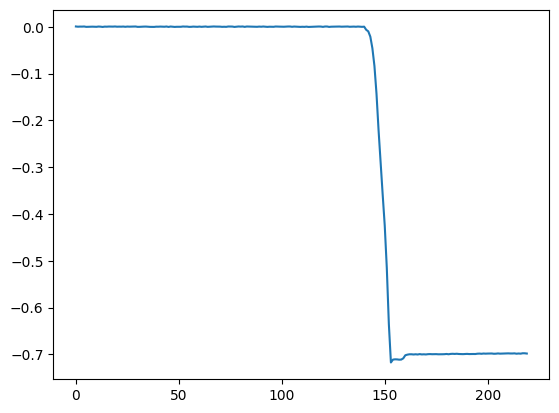

 ===========   plot for the 18-th observation dim   =========== 


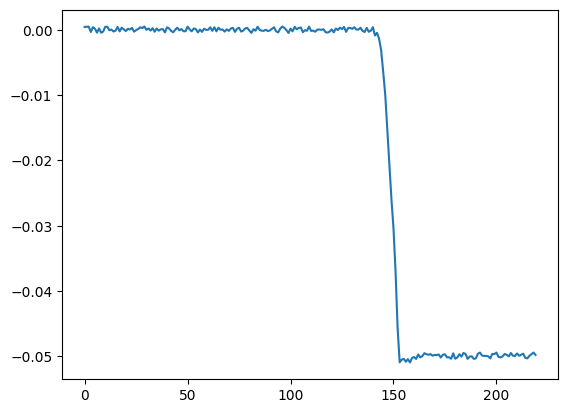

 ===========   plot for the 19-th observation dim   =========== 


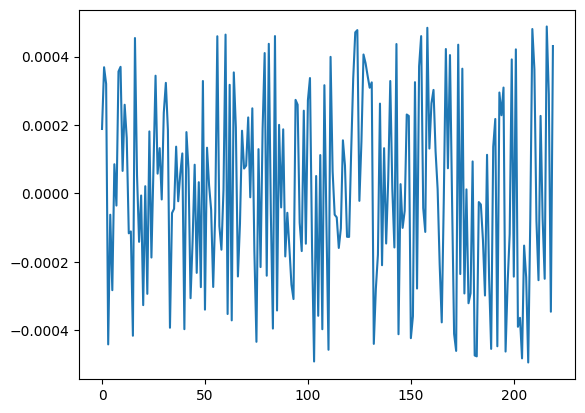

 ===========   plot for the 20-th observation dim   =========== 


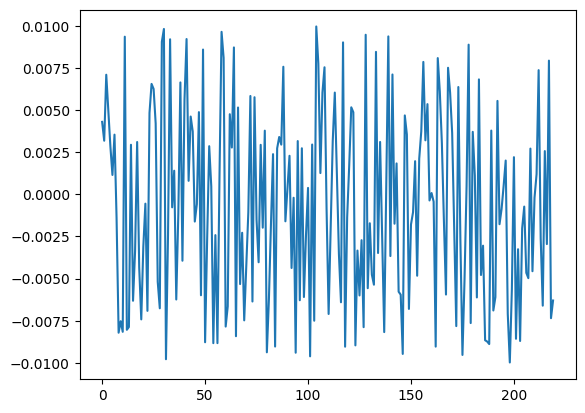

 ===========   plot for the 21-th observation dim   =========== 


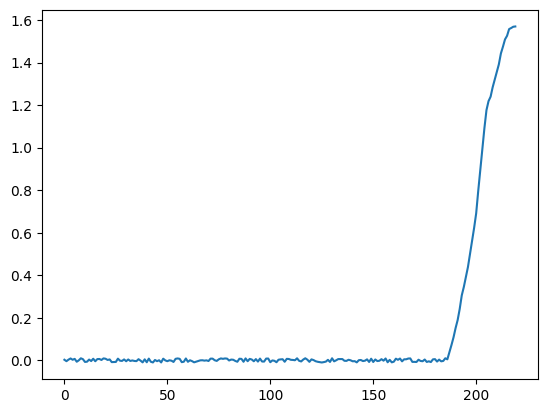

 ===========   plot for the 22-th observation dim   =========== 


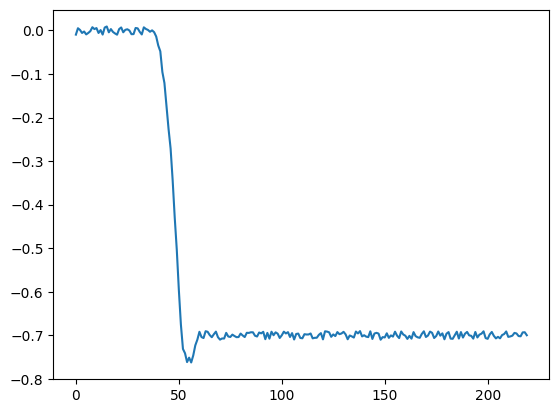

 ===========   plot for the 23-th observation dim   =========== 


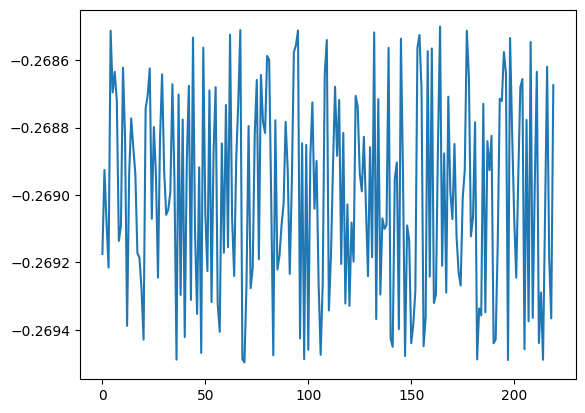

 ===========   plot for the 24-th observation dim   =========== 


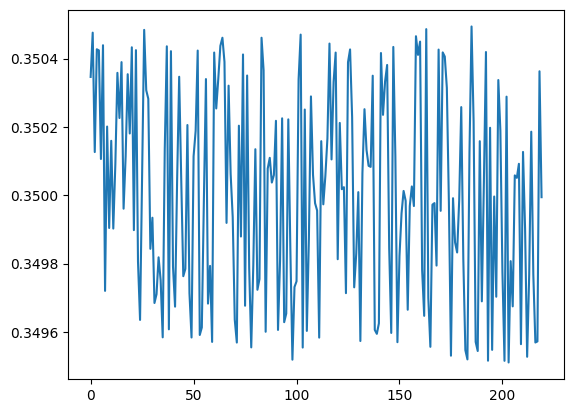

 ===========   plot for the 25-th observation dim   =========== 


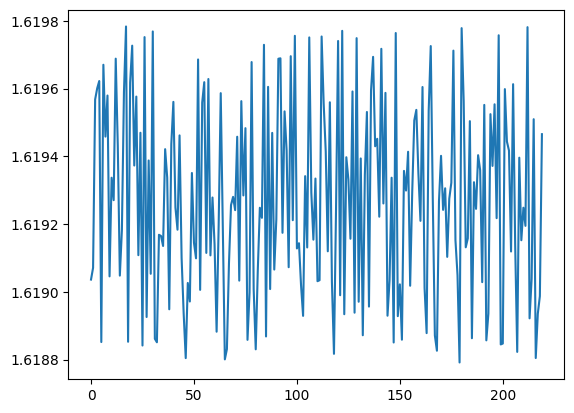

 ===========   plot for the 26-th observation dim   =========== 


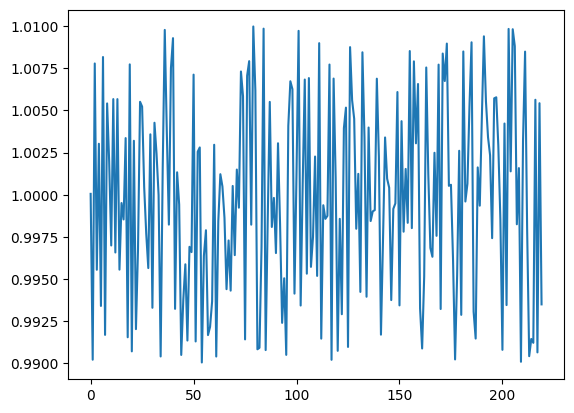

 ===========   plot for the 27-th observation dim   =========== 


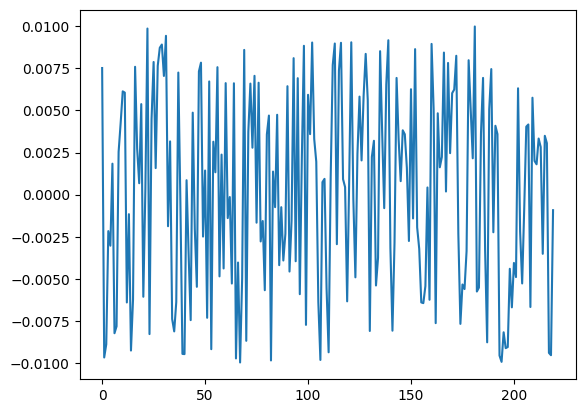

 ===========   plot for the 28-th observation dim   =========== 


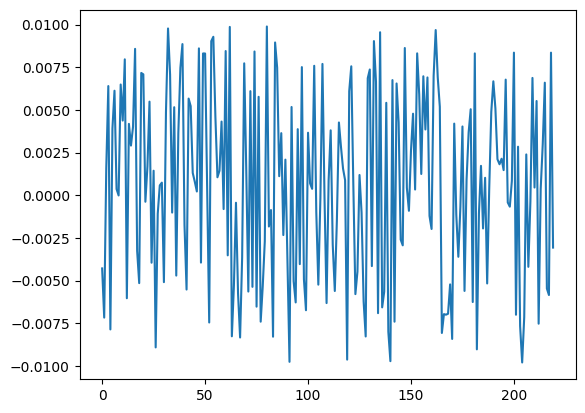

 ===========   plot for the 29-th observation dim   =========== 


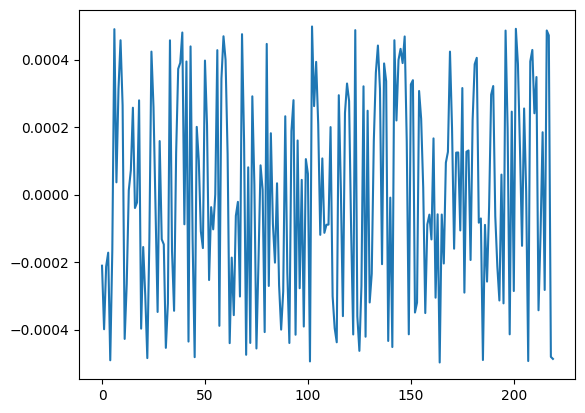

 ===========   plot for the 30-th observation dim   =========== 


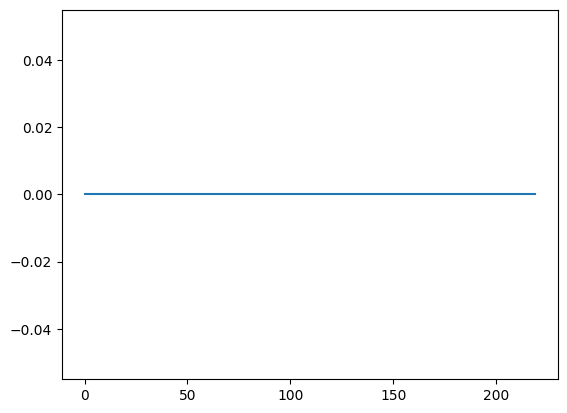

 ===========   plot for the 31-th observation dim   =========== 


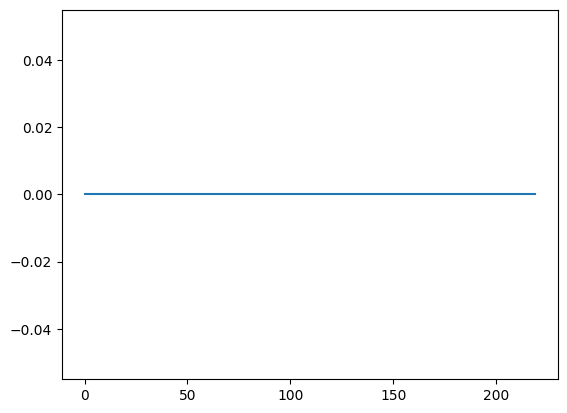

 ===========   plot for the 32-th observation dim   =========== 


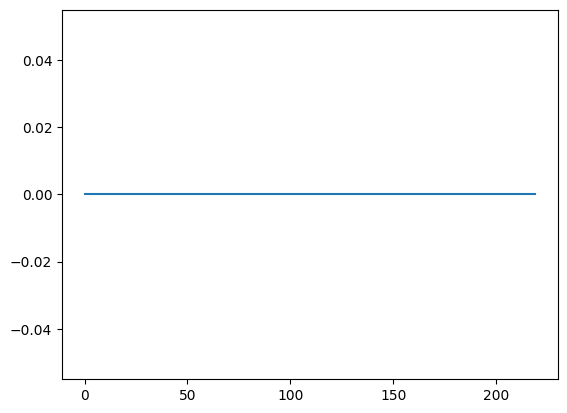

 ===========   plot for the 33-th observation dim   =========== 


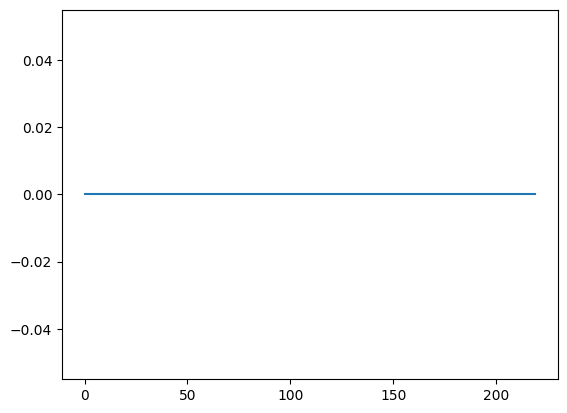

 ===========   plot for the 34-th observation dim   =========== 


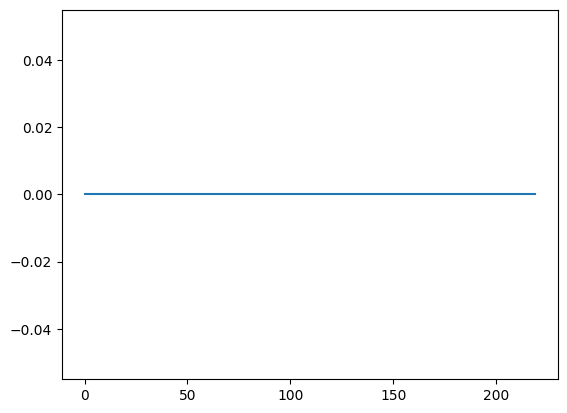

 ===========   plot for the 35-th observation dim   =========== 


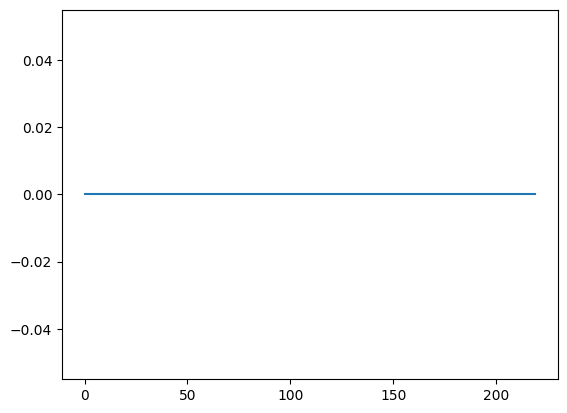

 ===========   plot for the 36-th observation dim   =========== 


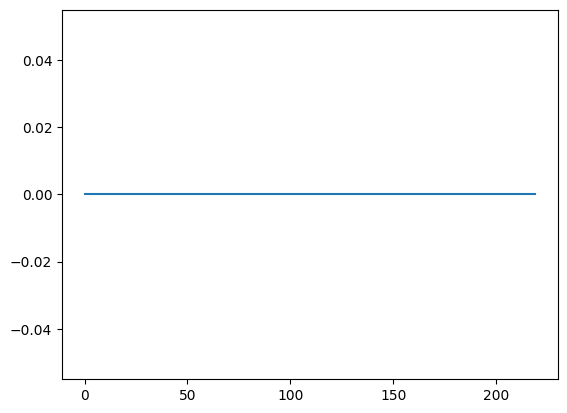

 ===========   plot for the 37-th observation dim   =========== 


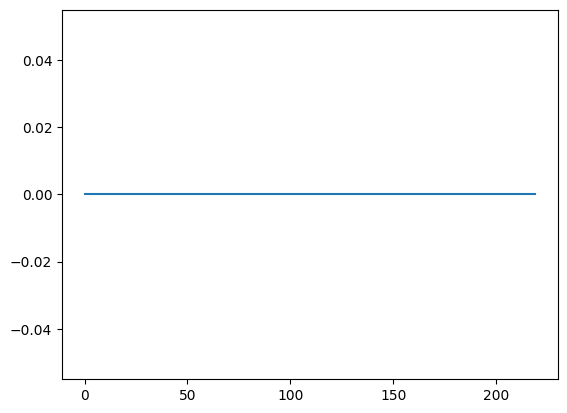

 ===========   plot for the 38-th observation dim   =========== 


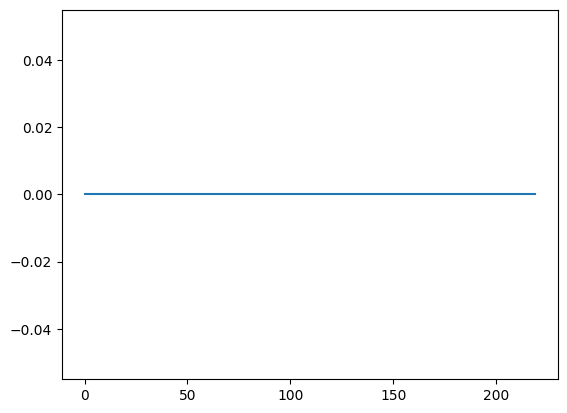

 ===========   plot for the 39-th observation dim   =========== 


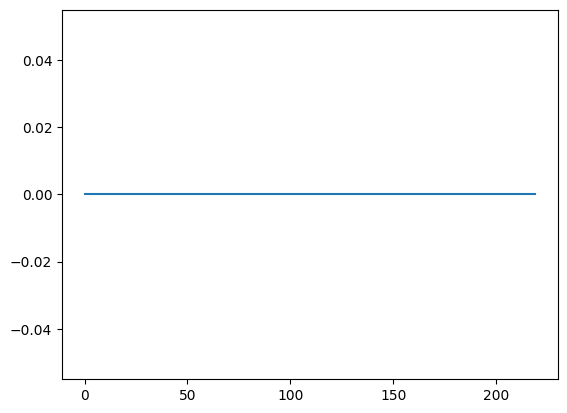

 ===========   plot for the 40-th observation dim   =========== 


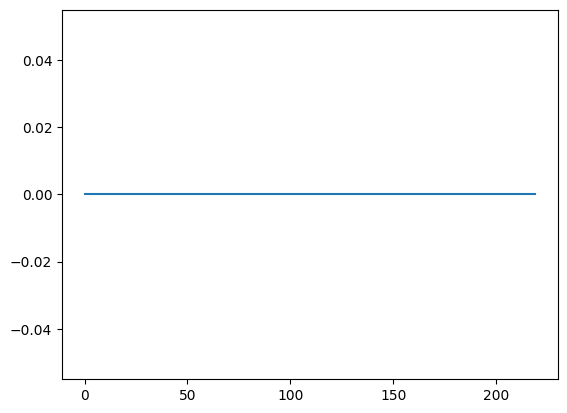

 ===========   plot for the 41-th observation dim   =========== 


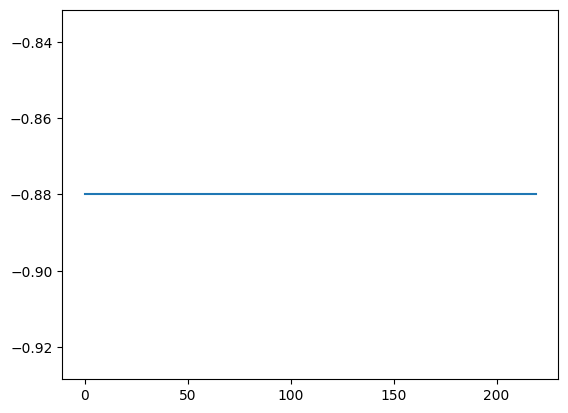

 ===========   plot for the 42-th observation dim   =========== 


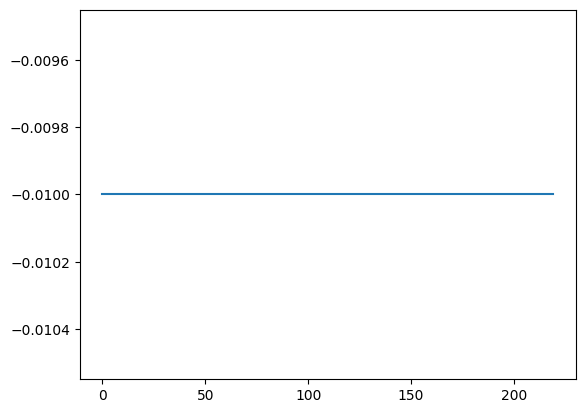

 ===========   plot for the 43-th observation dim   =========== 


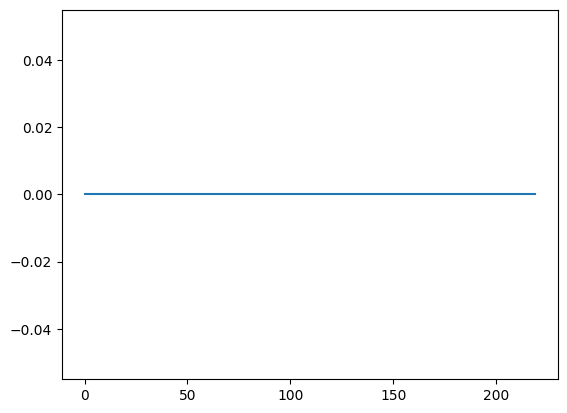

 ===========   plot for the 44-th observation dim   =========== 


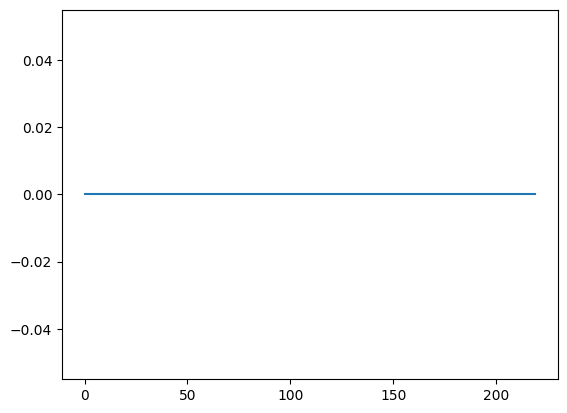

 ===========   plot for the 45-th observation dim   =========== 


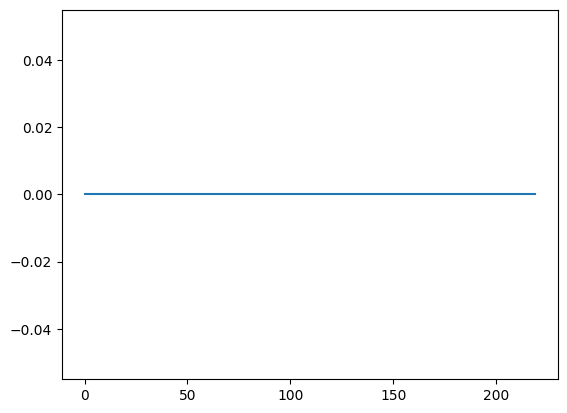

 ===========   plot for the 46-th observation dim   =========== 


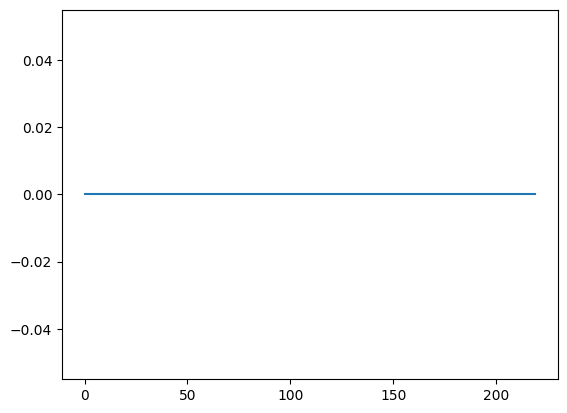

 ===========   plot for the 47-th observation dim   =========== 


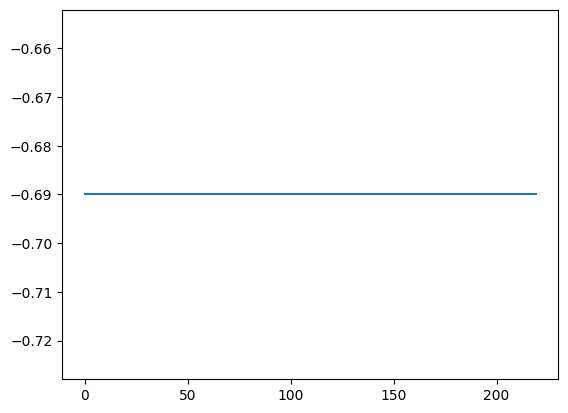

 ===========   plot for the 48-th observation dim   =========== 


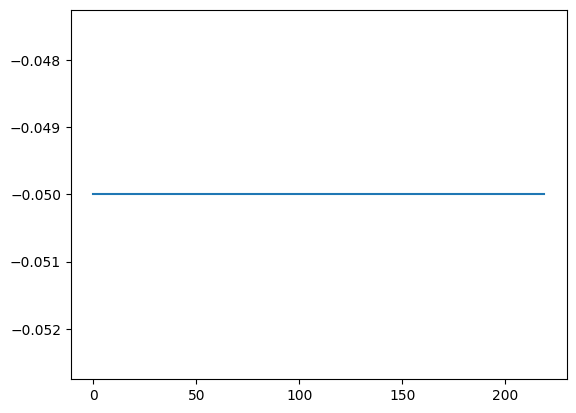

 ===========   plot for the 49-th observation dim   =========== 


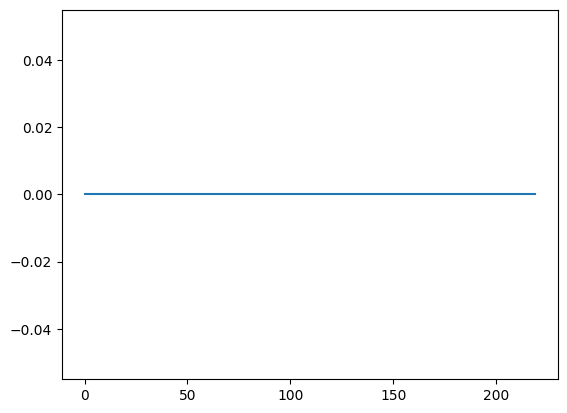

 ===========   plot for the 50-th observation dim   =========== 


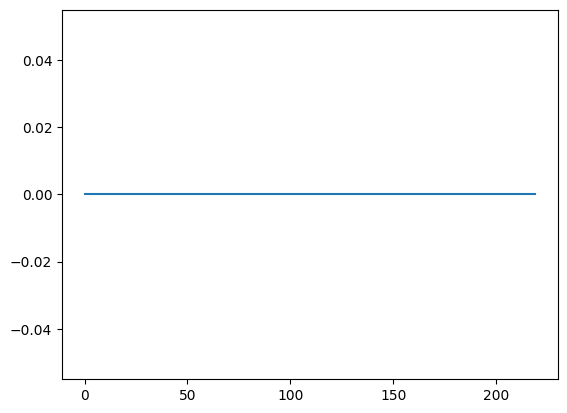

 ===========   plot for the 51-th observation dim   =========== 


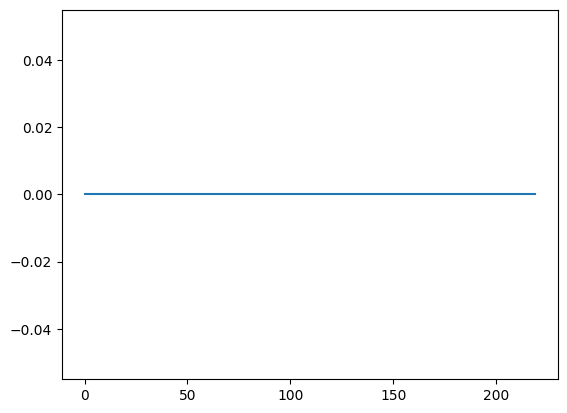

 ===========   plot for the 52-th observation dim   =========== 


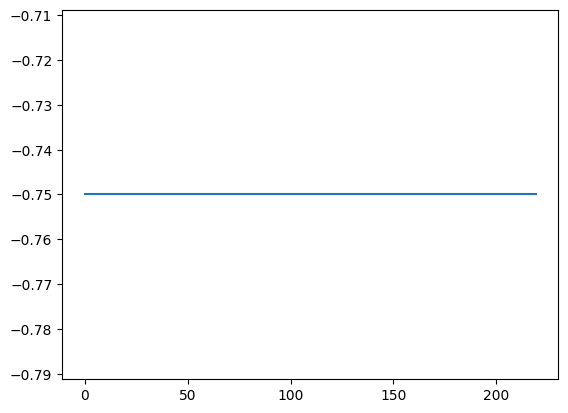

 ===========   plot for the 53-th observation dim   =========== 


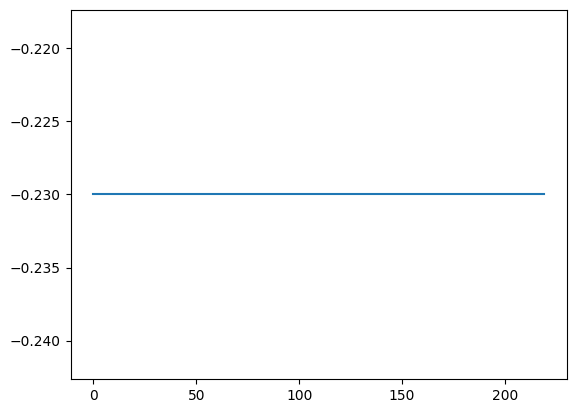

 ===========   plot for the 54-th observation dim   =========== 


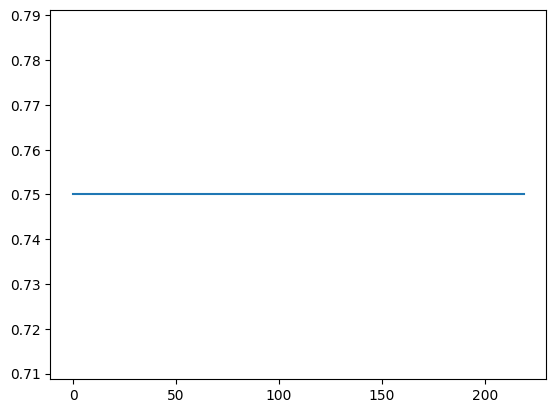

 ===========   plot for the 55-th observation dim   =========== 


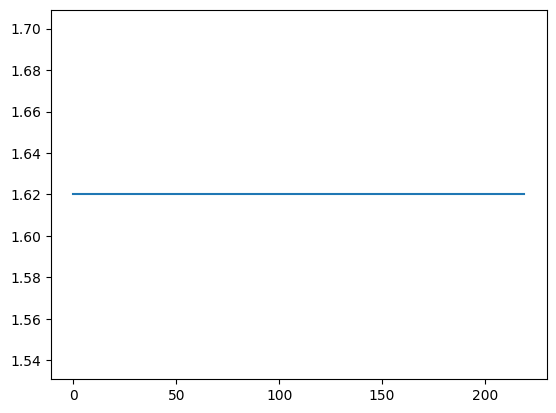

 ===========   plot for the 56-th observation dim   =========== 


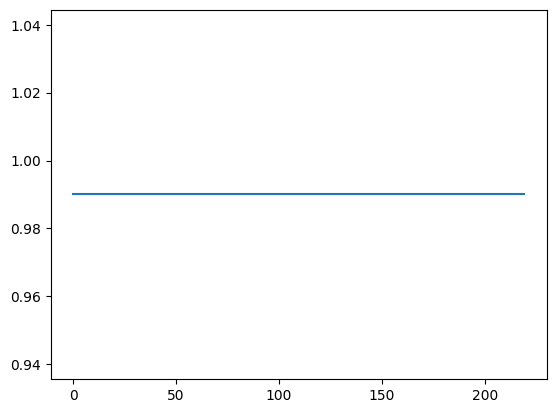

 ===========   plot for the 57-th observation dim   =========== 


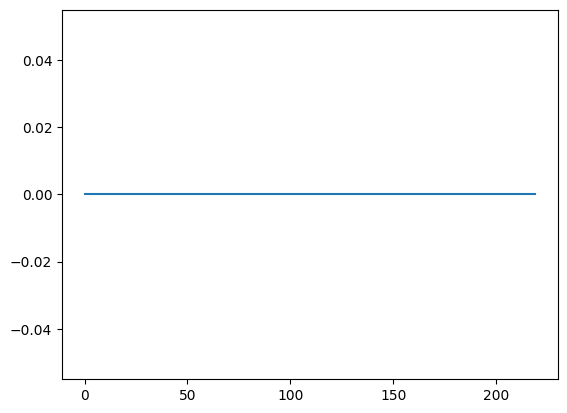

 ===========   plot for the 58-th observation dim   =========== 


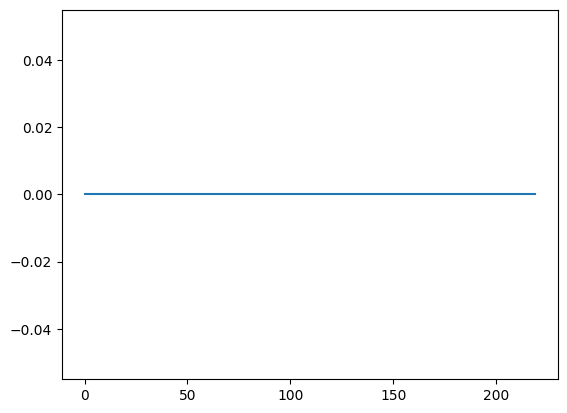

 ===========   plot for the 59-th observation dim   =========== 


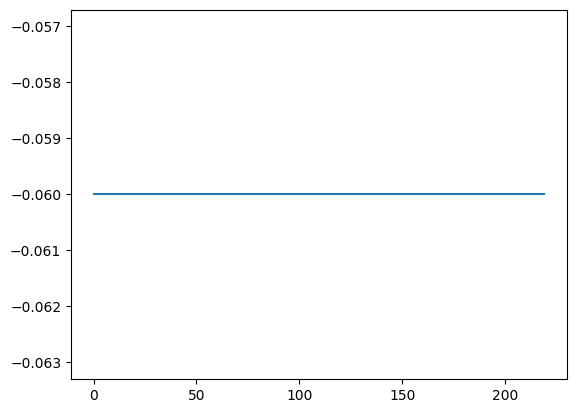

In [48]:
obs = mixed_sequences[1]['observations']
space_dim = obs.shape[1]
t = obs.shape[0]

for i in range(space_dim):
    
    print(f' ===========   plot for the {i}-th observation dim   =========== ') 
    plt.plot(np.arange(t), obs[:,i])
    plt.show()

In [44]:
env = gym.make('FrankaKitchen-v1')

In [45]:
obs = env.reset()

In [46]:
obs[0].keys()

dict_keys(['observation', 'achieved_goal', 'desired_goal'])

In [51]:
obs[0]['observation']

array([ 1.47401904e-01, -1.76790608e+00,  1.84329334e+00, -2.47752771e+00,
        2.60095025e-01,  7.12711226e-01,  1.59493935e+00,  4.72634555e-02,
        3.66986007e-02,  5.94627260e-04,  2.46185179e-04, -2.74824365e-04,
       -2.98777878e-04,  5.56175704e-04, -9.07653588e-04, -5.94770926e-04,
        6.21374911e-04,  6.25196377e-04, -2.89060704e-04, -5.19844296e-05,
        2.99764046e-05, -4.49725373e-05, -3.72561329e-06, -4.20679989e-05,
        6.30438886e-05,  4.03843797e-05,  4.62780714e-04, -2.26501499e-04,
       -4.67328756e-04, -6.44129366e-03, -1.77745523e-03,  1.07139130e-03,
       -2.69386106e-01,  3.50384238e-01,  1.61944733e+00,  9.99968448e-01,
        4.07597972e-03, -6.59337821e-03, -2.90233374e-04, -1.62886705e-06,
       -2.37673235e-08, -6.65830003e-08, -1.44168345e-06,  3.21325414e-07,
        1.69377971e-06,  1.16873355e-06, -1.76697668e-06, -2.77717359e-07,
        2.26811885e-06,  1.17635657e-06,  3.40544476e-05, -7.05127311e-06,
        4.47744701e-05, -

In [50]:
obs[1]

{'tasks_to_complete': ['light switch',
  'hinge cabinet',
  'bottom burner',
  'kettle',
  'top burner',
  'slide cabinet',
  'microwave'],
 'episode_task_completions': [],
 'step_task_completions': []}

In [65]:
for k in obs[0]['desired_goal']:
    print(f' {k} shape: {obs[0]["desired_goal"][k].shape}')

 bottom burner shape: (2,)
 top burner shape: (2,)
 light switch shape: (2,)
 slide cabinet shape: (1,)
 hinge cabinet shape: (2,)
 microwave shape: (1,)
 kettle shape: (7,)


In [106]:
class OptimalBuffer:
    def __init__(self, horizon, ratio=0.1, gamma=0.99):
        self.gamma = gamma
        self.ratio = ratio
        self.info = []
        self.horizon = horizon
        self.count = 0

    def insert_traj(self, info):
        current_total_reward = 0
        current_discounted_reward = 0
        trj_len = info['actions'].shape[0]
        for i in range(trj_len - 1, -1, -1):
            current_total_reward += info["rewards"][i]
            current_discounted_reward = (
                current_discounted_reward * self.gamma + info["rewards"][i]
            )
            if trj_len - i > self.horizon:
                current_info = {
                    "discounted_reward": current_discounted_reward,
                    "obs": info["observations"][i : i + self.horizon],
                    "segment_idx": i,
                }
                self.info.append(current_info)
                self.count += 1

    def sample_batch_traj(self, optim_batch, dataset, region_avoid):
        # stored in (d-rtg, obs:(100, obs_dim))

        sample_idx = []
        for k in self.region_map:
            if k not in region_avoid:
                sample_idx += self.region_map[k]

        batch_info = []
        batch_index = random.sample(sample_idx, optim_batch)
        batch_info = [self.info[_] for _ in batch_index]

        return batch_info

In [34]:
horizon = 60
data_buffer = OptimalBuffer(horizon)
for partial_trj in partial_sequences:
    data_buffer.insert_traj(partial_trj)

In [109]:
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import mutual_info_score, adjusted_rand_score

### Using whole sequence 

In [38]:
n_clusters = [5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    train_seq_x.append(data_buffer.info[idx]['obs'][:, :30].reshape(-1))

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    
    print(" ============= clustering with whole sequence ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")
    

 ============= clustering with whole sequence ============ 
Silhouette Score: 0.19
Davies-Bouldin Index: 1.72
Calinski-Harabasz Index: 20394.96
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.20
Davies-Bouldin Index: 1.64
Calinski-Harabasz Index: 15430.02
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.21
Davies-Bouldin Index: 1.56
Calinski-Harabasz Index: 11566.77
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.22
Davies-Bouldin Index: 1.51
Calinski-Harabasz Index: 8531.79


### Using the two end states

In [39]:
n_clusters = [5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    end_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(end_states.reshape(-1))


for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)

    
    print(" ============= clustering with two end states ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


 ============= clustering with two end states ============ 
Silhouette Score: 0.18
Davies-Bouldin Index: 1.71
Calinski-Harabasz Index: 20960.84
 ============= clustering with two end states ============ 
Silhouette Score: 0.20
Davies-Bouldin Index: 1.74
Calinski-Harabasz Index: 15650.73
 ============= clustering with two end states ============ 
Silhouette Score: 0.20
Davies-Bouldin Index: 1.66
Calinski-Harabasz Index: 11208.89
 ============= clustering with two end states ============ 
Silhouette Score: 0.23
Davies-Bouldin Index: 1.47
Calinski-Harabasz Index: 8595.82


### Using mean of sequence

In [40]:
n_clusters = [5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = data_buffer.info[idx]['obs'][:,:30].mean(axis=0)
    train_seq_x.append(mean_states)
    

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    print(" ============= clustering with sequence mean ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")
    

 ============= clustering with sequence mean ============ 
Silhouette Score: 0.26
Davies-Bouldin Index: 1.39
Calinski-Harabasz Index: 37786.78
 ============= clustering with sequence mean ============ 
Silhouette Score: 0.29
Davies-Bouldin Index: 1.32
Calinski-Harabasz Index: 28501.89
 ============= clustering with sequence mean ============ 
Silhouette Score: 0.26
Davies-Bouldin Index: 1.24
Calinski-Harabasz Index: 22535.96
 ============= clustering with sequence mean ============ 
Silhouette Score: 0.27
Davies-Bouldin Index: 1.17
Calinski-Harabasz Index: 19125.55


### Using Mean of two end states

In [42]:
n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(mean_states.mean(axis=0))

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    print(" ============= clustering with center of two end states ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")
    

 ============= clustering with center of two end states ============ 
Silhouette Score: 0.24
Davies-Bouldin Index: 1.39
Calinski-Harabasz Index: 38446.26
 ============= clustering with center of two end states ============ 
Silhouette Score: 0.19
Davies-Bouldin Index: 1.61
Calinski-Harabasz Index: 30156.34
 ============= clustering with center of two end states ============ 
Silhouette Score: 0.22
Davies-Bouldin Index: 1.50
Calinski-Harabasz Index: 22033.82
 ============= clustering with center of two end states ============ 
Silhouette Score: 0.22
Davies-Bouldin Index: 1.46
Calinski-Harabasz Index: 16178.83
 ============= clustering with center of two end states ============ 
Silhouette Score: 0.24
Davies-Bouldin Index: 1.40
Calinski-Harabasz Index: 12054.72


### Kitchen short trajectories

In [11]:
env_name = 'kitchen-partial-v0'
env = gym.make(env_name)

Reading configurations for Franka
Initializing Franka sim


/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [12]:
ds = env.get_dataset()

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.88it/s]


In [13]:
episodes = sequence_dataset(ds)

In [14]:
term = [seq['terminals'][-1] for seq in episodes]

In [15]:
def task_dataset(seq_dataset):
    
    tasks = []
    
    for seq in seq_dataset:
        
        task_data = collections.defaultdict(list)
        rewards = seq['rewards']
        
        l = rewards.shape[0]
        for i in range(l):
            
            for k in seq:
                task_data[k].append(seq[k][i])
            
            if rewards[i] == 1:
                for k in task_data:
                    task_data[k] = np.array(task_data[k])
                tasks.append(task_data)
                task_data = collections.defaultdict(list)
        
        
        if len(task_data) > 0:
            for k in task_data:
                task_data[k] = np.array(task_data[k])
            tasks.append(task_data)
        
        
    return tasks

In [16]:
tasks = task_dataset(episodes)

(array([133., 231., 108., 517., 303., 126.,  75.,  77., 142.,  91.,  75.,
         57.,  60.,  37.,  20.,  36.,   4.,   2.,   1.,   3.]),
 array([  1. ,  12.9,  24.8,  36.7,  48.6,  60.5,  72.4,  84.3,  96.2,
        108.1, 120. , 131.9, 143.8, 155.7, 167.6, 179.5, 191.4, 203.3,
        215.2, 227.1, 239. ]),
 <BarContainer object of 20 artists>)

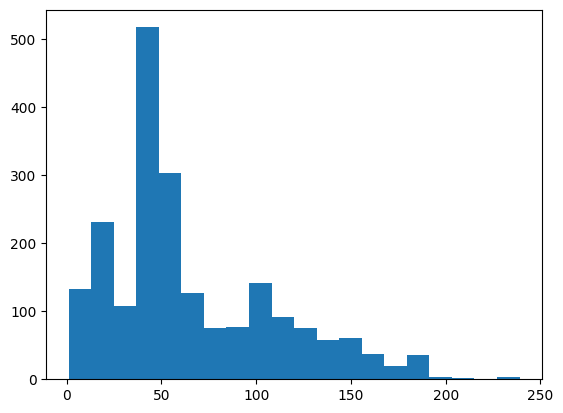

In [114]:
task_len = np.array([t['rewards'].shape[0] for t in tasks])
plt.hist(task_len, bins=20)

In [82]:
(task_len >= 60).sum() / task_len.shape[0]

0.3441077441077441

In [17]:
task_r = np.array([sum(t['rewards']) for t in tasks])

(array([   2.,  676., 1416.,    4.]),
 array([-1,  0,  1,  2,  3]),
 <BarContainer object of 4 artists>)

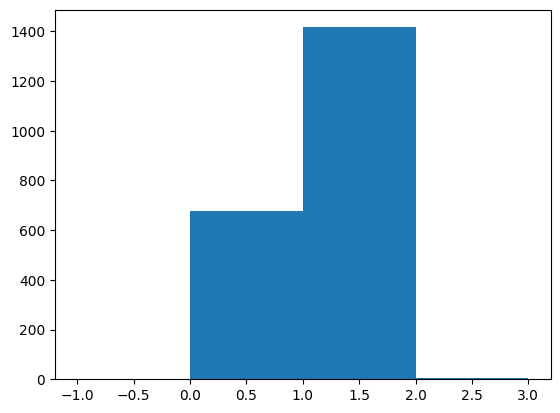

In [25]:
plt.hist(task_r, bins=[-1,0,1,2,3])

In [102]:
tasks[2]['rewards']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
      dtype=float32)

In [105]:
episodes[1]['rewards']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [117]:
zero_rewards_idx = np.where(task_r==0.0)[0]

In [118]:
zero_rewards_idx.shape

(676,)

In [97]:
task_len[zero_rewards_idx]

array([  4,   8,   4,   6, 153,   9,  10,  17,  60,   7,   6,   2,   2,
         5,   8,  10,   5,   4,   6,   3,   7,  82,  99,   6,   2,   6,
         4,   2,   2,   2,   6,   5,   4,   4,   2,   6,   2,   2,   4,
         2,   4,   5,   3,   3,   5,   3,   3,   4,   3,   2,   2,   7,
         3,   2,   9,   3,   4,   3,   3,   2,   5,   4,   2,   7,   8,
         8,   4,  99, 132])

In [92]:
len(tasks)

1485

In [72]:
tasks[zero_rewards_idx[4]]['rewards']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.], dtype=float32)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

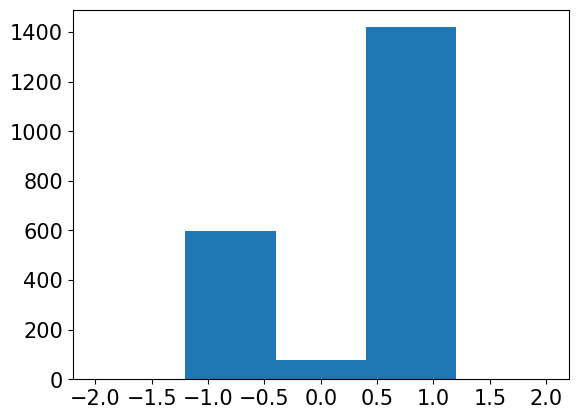

In [53]:
plt.hist(task_r, bins=5)
plt.xticks(size = 15)
plt.yticks(size = 15)

In [35]:
partial_return = np.array(comp_epi_return(tasks))

(array([  0.,  50., 100., 150., 200., 250., 300.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

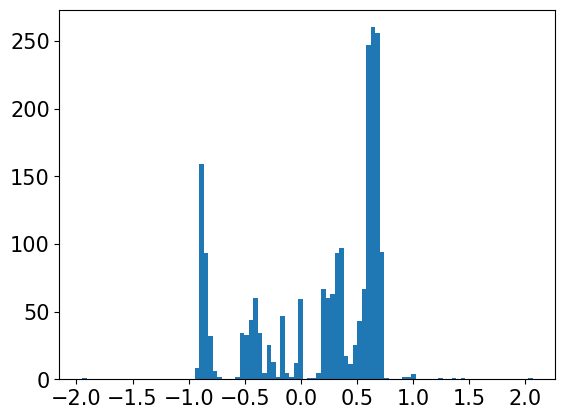

In [46]:
plt.hist(partial_return_v2, bins=100)
plt.xticks(size = 15)
plt.yticks(size = 15)

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.,
        9000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

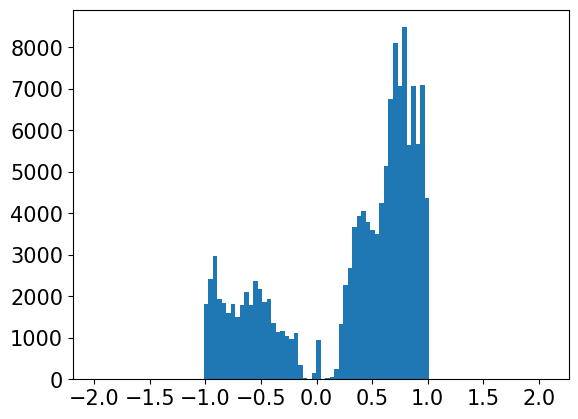

In [36]:
plt.hist(partial_return, bins=100)
plt.xticks(size = 15)
plt.yticks(size = 15)

In [37]:
partial_return_v2 = np.array(comp_epi_return_v2(tasks))

In [118]:
tasks[85921]['rewards']

IndexError: list index out of range

In [107]:
horizon = 60
data_buffer = OptimalBuffer(horizon)
for task in tasks:
    data_buffer.insert_traj(task)

In [110]:
n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
print(" ============= clustering with last state ============ ")

for idx in range(len(data_buffer.info)):

    train_seq_x.append(data_buffer.info[idx]['obs'][-1, :30])

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")

 ============= clustering with last state ============ 
Silhouette Score: 0.24
Davies-Bouldin Index: 1.39
Calinski-Harabasz Index: 20792.33
Silhouette Score: 0.19
Davies-Bouldin Index: 1.61
Calinski-Harabasz Index: 14948.81
Silhouette Score: 0.21
Davies-Bouldin Index: 1.40
Calinski-Harabasz Index: 10769.71
Silhouette Score: 0.22
Davies-Bouldin Index: 1.42
Calinski-Harabasz Index: 8045.16
Silhouette Score: 0.23
Davies-Bouldin Index: 1.38
Calinski-Harabasz Index: 6088.27


In [48]:
n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    train_seq_x.append(data_buffer.info[idx]['obs'][:, :30].reshape(-1))

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    
    print(" ============= clustering with whole sequence ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    end_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(end_states.reshape(-1))


for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)

    
    print(" ============= clustering with two end states ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = data_buffer.info[idx]['obs'][:,:30].mean(axis=0)
    train_seq_x.append(mean_states)
    

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    print(" ============= clustering with sequence mean ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(mean_states.mean(axis=0))

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    print(" ============= clustering with center of two end states ============ ")

    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")

 ============= clustering with whole sequence ============ 
Silhouette Score: 0.19
Davies-Bouldin Index: 1.88
Calinski-Harabasz Index: 8099.23
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.21
Davies-Bouldin Index: 1.77
Calinski-Harabasz Index: 6544.18
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.19
Davies-Bouldin Index: 1.81
Calinski-Harabasz Index: 4461.71
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.21
Davies-Bouldin Index: 1.60
Calinski-Harabasz Index: 3263.22
 ============= clustering with whole sequence ============ 
Silhouette Score: 0.24
Davies-Bouldin Index: 1.37
Calinski-Harabasz Index: 2717.38
 ============= clustering with two end states ============ 
Silhouette Score: 0.23
Davies-Bouldin Index: 1.58
Calinski-Harabasz Index: 9475.58
 ============= clustering with two end states ============ 
Silhouette Score: 0.20
Davies-Bouldin Index: 1.66
Calinski-Harabasz Index: 7339.54

In [51]:
horizon = 40
data_buffer = OptimalBuffer(horizon)
for task in tasks:
    data_buffer.insert_traj(task)

In [52]:
n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    train_seq_x.append(data_buffer.info[idx]['obs'][:, :30].reshape(-1))

print(" ============= clustering with whole sequence ============ ")

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    
    
    print(f' number of clusters: {n} ->:')
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    end_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(end_states.reshape(-1))

print(" ============= clustering with two end states ============ ")
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)

    
    

    print(f' number of clusters: {n} ->:')
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = data_buffer.info[idx]['obs'][:,:30].mean(axis=0)
    train_seq_x.append(mean_states)
    

print(" ============= clustering with sequence mean ============ ")
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    

    print(f' number of clusters: {n} ->:')
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")


n_clusters = [3, 5, 10, 20,40]

train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    mean_states = np.array([data_buffer.info[idx]['obs'][0,:30], data_buffer.info[idx]['obs'][-1,:30]])
    train_seq_x.append(mean_states.mean(axis=0))

print(" ============= clustering with center of two end states ============ ")
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, n_init='auto').fit(train_seq_x)
    silhouette = silhouette_score(train_seq_x, kmeans.labels_)
    db_index = davies_bouldin_score(train_seq_x, kmeans.labels_)
    ch_index = calinski_harabasz_score(train_seq_x, kmeans.labels_)
    
    
    

    print(f' number of clusters: {n} ->:')
    print(f"Silhouette Score: {silhouette:.2f}")
    print(f"Davies-Bouldin Index: {db_index:.2f}")
    print(f"Calinski-Harabasz Index: {ch_index:.2f}")

 ============= clustering with whole sequence ============ 
 number of clusters: 3 ->:
Silhouette Score: 0.18
Davies-Bouldin Index: 1.87
Calinski-Harabasz Index: 15482.61
 number of clusters: 5 ->:
Silhouette Score: 0.22
Davies-Bouldin Index: 1.78
Calinski-Harabasz Index: 13464.25
 number of clusters: 10 ->:
Silhouette Score: 0.24
Davies-Bouldin Index: 1.60
Calinski-Harabasz Index: 10800.71
 number of clusters: 20 ->:
Silhouette Score: 0.22
Davies-Bouldin Index: 1.52
Calinski-Harabasz Index: 7636.55
 number of clusters: 40 ->:
Silhouette Score: 0.26
Davies-Bouldin Index: 1.45
Calinski-Harabasz Index: 5982.83
 ============= clustering with two end states ============ 
 number of clusters: 3 ->:
Silhouette Score: 0.20
Davies-Bouldin Index: 1.80
Calinski-Harabasz Index: 15901.84
 number of clusters: 5 ->:
Silhouette Score: 0.24
Davies-Bouldin Index: 1.37
Calinski-Harabasz Index: 14338.28
 number of clusters: 10 ->:
Silhouette Score: 0.22
Davies-Bouldin Index: 1.73
Calinski-Harabasz Index:

In [27]:
episodes[0]['rewards'].shape

(228,)

In [227]:
def cosine_similarity(x, y):
    x_norm = np.linalg.norm(x, axis=1, keepdims=True)
    y_norm = np.linalg.norm(y, axis=1, keepdims=True)
    similarity = np.dot(x/x_norm, (y/y_norm).transpose())
    return similarity

def comp_distance(x, y):
    return np.linalg.norm(x-y, axis=-1)

In [158]:
horizon = 40
data_buffer = OptimalBuffer(horizon)
for task in tasks:
    data_buffer.insert_traj(task)

In [242]:
train_seq_x = []
train_seq_y = []
for idx in range(len(data_buffer.info)):

    train_seq_x.append(data_buffer.info[idx]['obs'][:, :30].mean(axis=0))

train_seq_x = np.array(train_seq_x)
kmeans = KMeans(n_clusters=10, n_init='auto').fit(train_seq_x)

In [243]:
pred_y = kmeans.labels_

In [244]:
np.unique(pred_y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [245]:
cluster_x = []
for i in range(10):
    cluster_idx = np.where(pred_y == i)[0]
    cluster_x.append(train_seq_x[cluster_idx])
    

In [249]:
cos_mean = []
for i in range(10):
    
    x = cluster_x[i]
    
    cos = cosine_similarity(x, x)
    print(f'cluster idx {i} size: {x.shape[0]}, cos similarity: mean: {cos.mean()}\t max: {cos.max()}\t min: {cos.min()}')
    
    cos_mean.append(cos.mean())
print(f' total cos mean: {np.mean(cos_mean)}')

cluster idx 0 size: 11037, cos similarity: mean: 0.9861477017402649	 max: 1.0000003576278687	 min: 0.8688315153121948
cluster idx 1 size: 6724, cos similarity: mean: 0.9861366748809814	 max: 1.0000003576278687	 min: 0.8374577760696411
cluster idx 2 size: 4308, cos similarity: mean: 0.9736767411231995	 max: 1.0000003576278687	 min: 0.8831625580787659
cluster idx 3 size: 6965, cos similarity: mean: 0.982701301574707	 max: 1.0000003576278687	 min: 0.7828146815299988
cluster idx 4 size: 4533, cos similarity: mean: 0.9627440571784973	 max: 1.0000003576278687	 min: 0.8231271505355835
cluster idx 5 size: 9434, cos similarity: mean: 0.984697699546814	 max: 1.0000004768371582	 min: 0.9047510027885437
cluster idx 6 size: 3361, cos similarity: mean: 0.9686737060546875	 max: 1.0000003576278687	 min: 0.861215353012085
cluster idx 7 size: 2984, cos similarity: mean: 0.9469130039215088	 max: 1.0000003576278687	 min: 0.7769402861595154
cluster idx 8 size: 9242, cos similarity: mean: 0.9843795895576477

In [248]:
inter_cos_mean = []
for i in range(1, 10):
    
    x = cluster_x[i][:4000]
    for j in range(i):
        y = cluster_x[j][:4000]
        cos = cosine_similarity(x, y)
        print(f'cos similarity between {i} and {j} is : mean: {cos.mean()}\t max: {cos.max()}\t min: {cos.min()}')
    
    inter_cos_mean.append(cos.mean())
print(f' total cos mean: {np.mean(inter_cos_mean)}')

cos similarity between 1 and 0 is : mean: 0.9331145286560059	 max: 0.9999383687973022	 min: 0.7493162155151367
cos similarity between 2 and 0 is : mean: 0.9537519812583923	 max: 0.9999878406524658	 min: 0.8394201397895813
cos similarity between 2 and 1 is : mean: 0.910815417766571	 max: 0.987420916557312	 min: 0.7162571549415588
cos similarity between 3 and 0 is : mean: 0.9480900168418884	 max: 0.9988085031509399	 min: 0.7580870985984802
cos similarity between 3 and 1 is : mean: 0.9013110399246216	 max: 0.9831225872039795	 min: 0.5053303241729736
cos similarity between 3 and 2 is : mean: 0.8798915147781372	 max: 0.965350866317749	 min: 0.6221412420272827
cos similarity between 4 and 0 is : mean: 0.9037445783615112	 max: 0.9757937788963318	 min: 0.6974716186523438
cos similarity between 4 and 1 is : mean: 0.917015552520752	 max: 0.9848687648773193	 min: 0.7447717785835266
cos similarity between 4 and 2 is : mean: 0.9176414608955383	 max: 0.9879087805747986	 min: 0.719778299331665
cos si

array([[0.9999998 , 0.9998487 , 0.9993851 , 0.9986046 , 0.99415654],
       [0.9998487 , 1.0000002 , 0.99984384, 0.99937224, 0.9953438 ],
       [0.9993851 , 0.99984384, 0.99999994, 0.99984205, 0.99624616],
       [0.9986046 , 0.99937224, 0.99984205, 1.        , 0.9968486 ],
       [0.99415654, 0.9953438 , 0.99624616, 0.9968486 , 0.9999999 ]],
      dtype=float32)

In [195]:
cluster_x[0].shape

(1088, 30)

In [176]:
len(data_buffer.info)

63699

In [225]:
x = np.linalg.norm(cluster_x[0], axis=1, keepdims=True)

In [226]:
x.shape

(1088, 1)

In [257]:
obs = tasks[1]['observations']

In [267]:
np.linalg.norm(obs[:-1] - obs[1:], axis=-1).max()

0.15478006

In [264]:
cos = cosine_similarity(obs[:10], obs[:10])

In [266]:
cos[0]

array([0.9999999 , 0.99952364, 0.998178  , 0.9961525 , 0.99334216,
       0.989942  , 0.98623157, 0.98291487, 0.9790444 , 0.97617334],
      dtype=float32)

In [269]:
ds = env.get_dataset()

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 28.86it/s]


In [272]:
N = ds['rewards'].shape[0]

In [289]:
rewards = []
r = []
use_timeouts = "timeouts" in ds
for i in range(N):

    
    done_bool = bool(ds["terminals"][i])
    if use_timeouts:
        final_timestep = ds["timeouts"][i]
    else:
        final_timestep = episode_step == env.max_episode_steps - 1

    r.append(ds['rewards'][i])

    if done_bool or final_timestep:
        rewards.append(np.array(r))
        r = []

    

In [290]:
processed_r = [r[1:] - r[:-1] for r in rewards]

In [292]:
neg_rew = [(r<0).any() for r in processed_r]

In [293]:
np.where(np.array(neg_rew))[0]

array([ 84,  96, 186, 187, 210, 302, 308, 311, 315, 336, 344, 384, 389,
       391, 394, 396, 403, 415, 429, 439, 466, 470, 498, 510, 518, 524,
       557, 563, 601])

In [299]:
rewards[210]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [295]:
processed_r[84]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [308]:
last_r = np.array([r[-1] for r in rewards])

In [309]:
np.where(last_r == 4)[0]

array([525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537,
       538, 539, 540, 541, 542, 543])

In [314]:
rewards[529]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4.], dtype=float32)

In [315]:
ds['rewards'].shape[0]

136950

In [316]:
len(processed_r)

613

In [326]:
ds.keys()

dict_keys(['actions', 'infos', 'observations', 'rewards', 'terminals', 'timeouts'])

In [325]:
sum(ds['timeouts'])

12

In [327]:
sum(ds['terminals'])

601